## Tutorial PAMAP2 with mcfly

This turorial is intended to talk you through the functionalities of mcfly. As an example dataset we use the publicly available PAMAP2 dataset. It contains time series data from a variety of sensors worn by nine persons. The data is labelled with the activity types these individuals did.

Before you can start, please make sure you installed all the dependencies of mcfly (listed in requirements.txt) and make sure your jupyter notebook has a python3 kernel.

## Import required Python modules

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import numpy as np
import pandas as pd
# mcfly
from mcfly import tutorial_pamap2, modelgen, find_architecture
# Keras module is use for the deep learning
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
# We can set some backend options to avoid NaNs
from keras import backend as K

Using Theano backend.


float32
1e-07


## Download data and pre-proces data

We have created a function for you to fetch and pre-proces the data. Please specify the directory_to_extract_to and then execute the cells.

In [2]:
# Specify in which directory you want to store the data:
directory_to_extract_to = "/media/windows-share"
# Specifcy which columns to use. You can leave this as it is
columns_to_use = ['hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z',
                 'ankle_acc_16g_x', 'ankle_acc_16g_y', 'ankle_acc_16g_z',
                 'chest_acc_16g_x', 'chest_acc_16g_y', 'chest_acc_16g_z']

In [3]:
outputpath = tutorial_pamap2.fetch_and_preprocess(directory_to_extract_to,columns_to_use)

Data previously downloaded and stored in /media/windows-share/PAMAP2
Data previously pre-processed and np-files saved to /media/windows-share/PAMAP2/PAMAP2_Dataset/slidingwindow512cleaned/


## Load the pre-processed data

Load the preprocessed data as stored in Numpy-files

In [4]:
X_train, y_train_binary, X_val, y_val_binary, X_test, y_test_binary = tutorial_pamap2.load_data(outputpath)

## Generate models

First step is to create a model architecture. As we do not know whart architecture is best for our data we will create a random set of models. You will need to specificy how many models, the type of model, maximum number of layers per modeltype. See for more information the function documentation: ?modelgen.generate_models

In [7]:
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 3, #10,
                                  model_type = 'CNN',
                                  cnn_max_layers=4,
                                  deepconvlstm_max_conv_layers=3,
                                  deepconvlstm_max_lstm_layers=2
                                 )

CPU times: user 2.19 s, sys: 272 ms, total: 2.46 s
Wall time: 3.28 s


In [8]:
for model, params, model_types in models:
    print(params)
    model.summary()

{'filters': array([95, 90, 21, 94]), 'regularization_rate': 0.015152595083635725, 'learning_rate': 0.0002269403988334344, 'fc_hidden_nodes': 1195}
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
batchnormalization_1 (BatchNormaliz(None, 512, 9)      18          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 512, 95)     2660        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormaliz(None, 512, 95)     190         convolution1d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 512

## Compare models

In [9]:
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=5,
                                                                                  subset_size=500,
                                                                                  verbose=True)

Training model 0 CNN


WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 500 samples, validate on 2007 samples
Epoch 1/5
500/500 [==============================] - 92s - loss: 22.4451 - acc: 0.5440 - val_loss: 1.0805 - val_acc: 0.7982
Epoch 2/5
500/500 [==============================] - 105s - loss: 16.9409 - acc: 0.8320 - val_loss: 0.9866 - val_acc: 0.8465
Epoch 3/5
500/500 [==============================] - 111s - loss: 12.6437 - acc: 0.8820 - val_loss: 0.9857 - val_acc: 0.8465
Epoch 4/5
500/500 [==============================] - 103s - loss: 9.8353 - acc: 0.9180 - val_loss: 0.9079 - val_acc: 0.8421
Epoch 5/5
500/500 [==============================] - 99s - loss: 8.0592 - acc: 0.9280 - val_loss: 0.9530 - val_acc: 0.8012
Training model 1 CNN
Train on 500 samples, validate on 2007 samples
Epoch 1/5
500/500 [==============================] - 12s - loss: 12.5201 - acc: 0.5960 - val_loss: 1.1791 - val_acc: 0.5396
Epoch 2/5
500/500 [==============================] - 12s - loss: 13.2551 - acc: 0.7420 - val_loss: 1.0203 - val_acc: 0.7015
Epoch 3/5
500/50

CPU times: user 368 ms, sys: 40 ms, total: 408 ms
Wall time: 444 ms


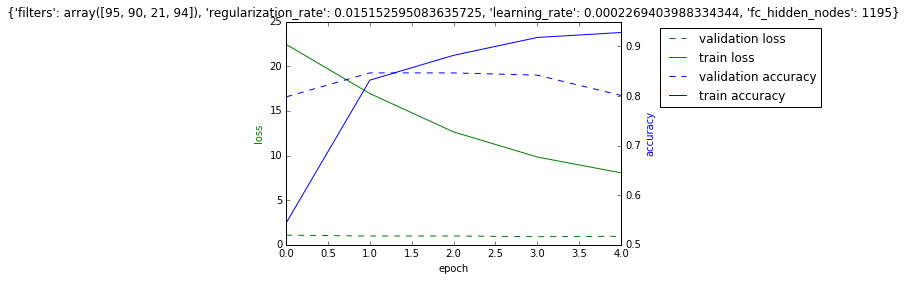

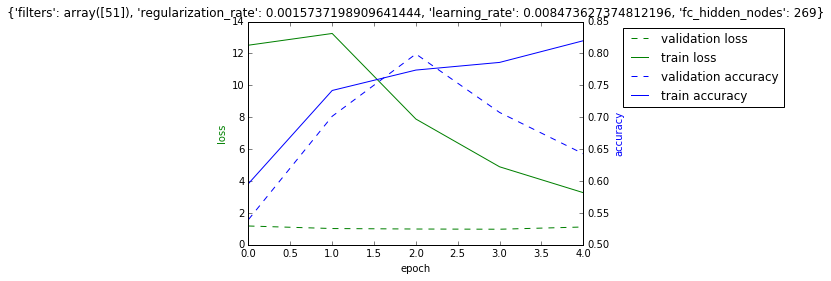

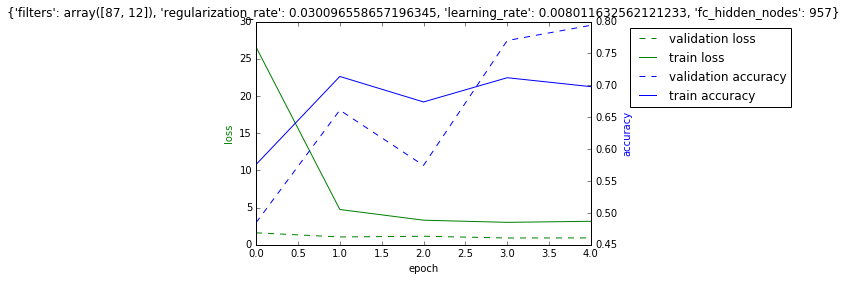

In [10]:
%matplotlib inline
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)
    

In [11]:

modelcomparisons = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
modelcomparisons

,model,train_acc,train_loss,val_acc,val_loss
0,"{'filters': array([95, 90, 21, 94]), 'regulari...",0.928,8.059159,0.801196,0.952981
1,"{'filters': array([51]), 'regularization_rate'...",0.820,3.270393,0.642750,1.116969
2,"{'filters': array([87, 12]), 'regularization_r...",0.698,3.161232,0.794220,0.926371


In [12]:
resultpath = directory_to_extract_to + '/PAMAP2/PAMAP2_Dataset/results/' 
if not os.path.exists(resultpath):
        os.makedirs(resultpath)

In [ ]:
# INSERT JSON FILE STORAGE, MAYBE REMOVE MODELCOMPARISON STORAGE TO CSV

In [13]:
modelcomparisons.to_csv(resultpath +'modelcomparisons.csv')

## Train the best model for real

In [ ]:
best_model_index = np.argmax(val_accuracies)
#best_model_index = 3

In [ ]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

In [ ]:
#We make a copy of the model, to start training from fresh
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'], best_params['regularization_rate'])

In [ ]:
#We're going to train the model on the complete data set, and save the model after each epoch
nr_epochs = 10
datasize = X_train.shape[0]#1000
history = best_model_copy.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary), 
                              callbacks=[keras.callbacks.ModelCheckpoint(datapath+'weights.{epoch:02d}-{val_loss:.2f}.hdf5')])

In [ ]:
# If we plot the training process, we see that the model is probably already overfitting in the first epoch. 
find_architecture.plotTrainingProcess(history)

In [ ]:
#Load model from the just before we get the NaNs
model_copy = keras.models.copy.copy(best_model_copy)
model_copy.load_weights(datapath+'weights.{epoch:02d}-{val_loss:.2f}.hdf5'.format(epoch=3, val_loss=0.22))
model_copy.compile(best_model_copy.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_copy = best_model_copy
model_copy.evaluate(X_train, y_train_binary)

In [ ]:
## Inspect model predictions
datasize = X_val.shape[0]
probs = best_model_copy.predict_proba(X_val[:datasize,:,:],batch_size=1)
probs

In [ ]:
# with a Sequential model
get_dens_layer_output = K.function([best_model_copy.layers[0].input, K.learning_phase()],
                                  [best_model_copy.layers[0].output])
layer_output = get_dens_layer_output([X_val, 0])[0]
layer_output

In [ ]:
score_val = best_model_copy.evaluate(X_val, y_val_binary, verbose=True)
score_val

In [ ]:
## Test on Testset
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))